<a href="https://colab.research.google.com/github/bachvu98/Policy-NLP/blob/master/First_Party_Collection_Model_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
import time
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from os import listdir
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, recall_score, f1_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from lxml import etree, html

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
segments = pd.read_csv('/content/drive/My Drive/OPP-115/OPP-115/binary_segment_categories.csv',index_col=0)
segments = segments[['Policy UID','segment_id','segments','first_party_collection_use']]
segments.head()

,Policy UID,segment_id,segments,first_party_collection_use
0,20,0,privacy policy effective january atlantic mont...,0
1,20,1,privacy policy apply site maintained company o...,0
2,20,2,visiting site accepting practice described pri...,0
3,20,3,information collected collect two basic type i...,1
4,20,4,personally identifiable information general ma...,1


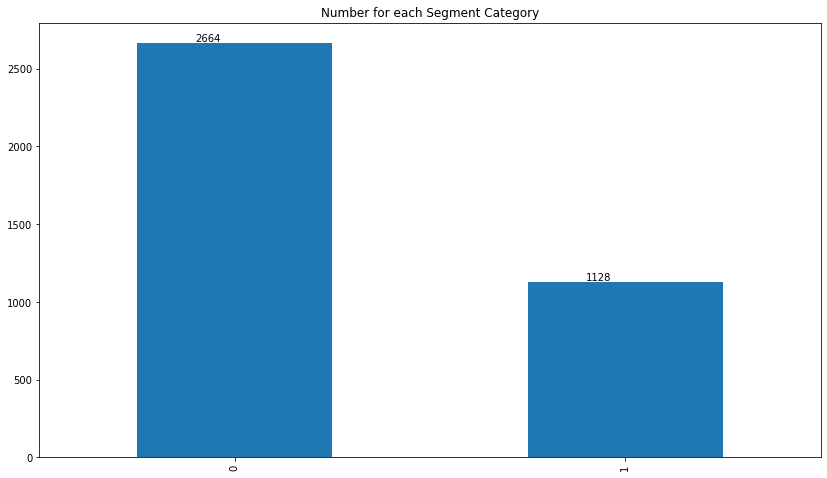

In [77]:
ax = segments['first_party_collection_use'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Segment Category")

for index, value in enumerate(segments['first_party_collection_use'].value_counts()):
    ax.text(index-0.1, value+10, "{}".format(value))

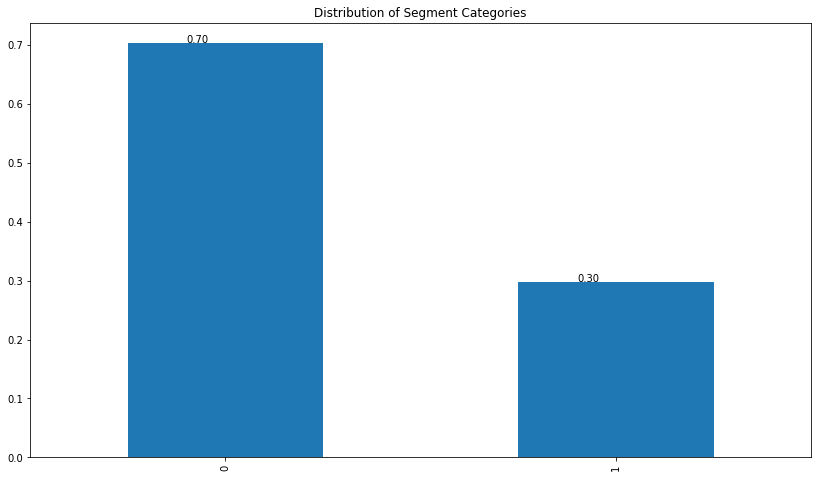

In [78]:
ax = segments['first_party_collection_use'].value_counts(normalize=True).plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Segment Categories")

for index, value in enumerate(segments['first_party_collection_use'].value_counts(normalize=True)):
    ax.text(index-0.1, value+0.002, "{:.2f}".format(value))

In [196]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english", ngram_range=(1,2), min_df=5, max_df=0.7, use_idf=True)
# fit the vectorizer using the text data
tfid = tfid_vectorizer.fit(segments['segments'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

tfid_matrix = tfid_vectorizer.transform(segments['segments']).todense()
feature_names = tfid_vectorizer.get_feature_names()

# store the tf-idf array into pandas dataframe
df = pd.DataFrame(tfid_matrix, columns=feature_names)
df['output'] = segments['first_party_collection_use']
df

,aaa,abide,ability,ability accept,ability access,abita,abitacom,able,able access,able identify,able provide,able take,able use,absolute,absolute security,abuse,acc,accept,accept change,accept cooky,accept request,acceptance,acceptance privacy,accepted,accepting,accepting new,accepting practice,access,access account,access certain,access change,access contact,access control,access cooky,access correct,access correction,access database,access disclosure,access enforcement,access information,...,word,work,work behalf,working,world,worldnowcom,would,would like,write,write kaleida,write privacy,writing,written,written authorization,written consent,written request,wwwaboutadsinfo,wwwaboutadsinfochoices,wwwexportgovsafeharbor,wwwnetworkadvertisingorgmanagingoptoutasp,yahoo,yahoo ad,yahoo also,year,year age,year free,year old,yet,york,york ny,york time,young,youtube,zacks,zacks investment,zackscom,zip,zip code,zone,output
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075825,0.11059,0.0,0.0,0.0,0.0,0.0,0.091806,0.0,0.105672,0.046098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.079999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.060860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136284,0.173288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...

In [197]:
#Split data using 30%/70% split
segments_train, segments_test, targets_train, targets_test = train_test_split(df[feature_names], df['output'], test_size=0.3, random_state=0)

In [233]:
alpha_list = np.linspace(0.1,3,30)
alpha_list = np.around(alpha_list, decimals=4)
alpha_list

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [234]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=False)
params = {'C': alpha_list,
          'random_state': [0]
          }

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [229]:
classifier = LogisticRegression(random_state=0)
cross_val_score(classifier, segments_train, targets_train, cv=kf, scoring='average_precision').mean()

0.8765182335708758

In [230]:
classifier.fit(segments_train, targets_train)
base_preds = classifier.predict(segments_test)
print(confusion_matrix(targets_test.astype(str), base_preds.astype(str)))
print(average_precision_score(targets_test,base_preds))

[[764  41]
 [123 210]]
0.6357036112425802


In [235]:
grid_no_up = GridSearchCV(classifier, param_grid=params, cv=kf, scoring='average_precision').fit(segments_train, targets_train)
print(grid_no_up.best_params_)
print(grid_no_up.best_score_)

{'C': 3.0, 'random_state': 0}
0.8819803061455284


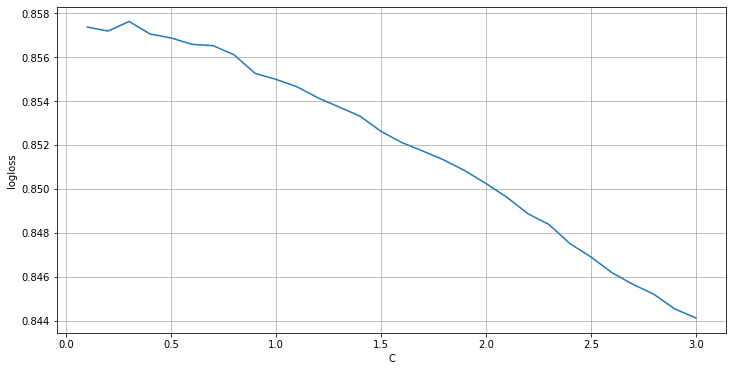

In [224]:
results = pd.DataFrame()
# collect parameter list
results['alpha'] = grid_no_up.cv_results_['param_alpha'].data
# collect test scores
results['score'] = grid_no_up.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['alpha'], results['score'])
plt.xlabel('C')
plt.ylabel('logloss')
plt.grid()

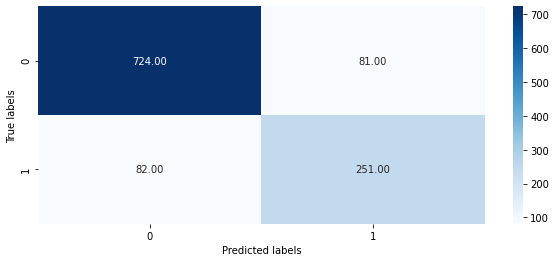

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       805
           1       0.76      0.75      0.75       333

    accuracy                           0.86      1138
   macro avg       0.83      0.83      0.83      1138
weighted avg       0.86      0.86      0.86      1138



In [225]:
grid_no_up_preds = grid_no_up.best_estimator_.predict(segments_test)
#labels = segments['do_not_track'].unique()
cm = confusion_matrix(targets_test.astype(str), grid_no_up_preds.astype(str))
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (10, 4)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

#Quick diagnostics
print(classification_report(targets_test.astype(str),grid_no_up_preds.astype(str)))

In [226]:
average_precision_score(targets_test,grid_no_up_preds)

0.6419122395947093

In [227]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

In [228]:
imba_pipeline = make_pipeline(SMOTE(random_state=0), 
                             LogisticRegression(random_state=0))

new_params = {'logisticregression__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='average_precision').fit(segments_train, targets_train)

ValueError: ignored

In [192]:
print(grid_imba.best_params_)
print(grid_imba.best_score_)

{'logisticregression__C': 1.6, 'logisticregression__random_state': 0}
0.9335085345782529


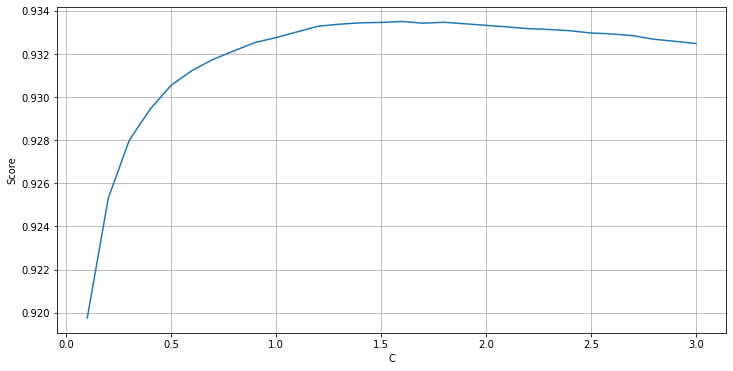

In [193]:
results = pd.DataFrame()
# collect alpha list
results['C'] = grid_imba.cv_results_['param_logisticregression__C'].data
# collect test scores
results['score'] = grid_imba.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['C'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

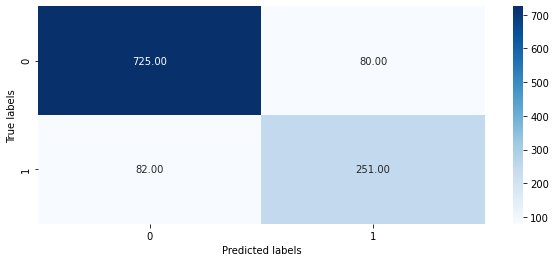

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       805
           1       0.76      0.75      0.76       333

    accuracy                           0.86      1138
   macro avg       0.83      0.83      0.83      1138
weighted avg       0.86      0.86      0.86      1138



In [194]:
grid_imba_preds = grid_imba.best_estimator_.named_steps['logisticregression'].predict(segments_test)
#labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), grid_imba_preds.astype(str))
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (10, 4)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

#Quick diagnostics
print(classification_report(targets_test,grid_imba_preds))

In [195]:
roc_auc_score(targets_test,grid_imba_preds)

0.8271874358830881

In [149]:
smote = SMOTE('minority', random_state=0)
segments_smote, targets_smote = smote.fit_sample(segments_train, targets_train)
smote_df = pd.concat([pd.DataFrame(segments_smote, columns=feature_names), pd.DataFrame(targets_smote, columns=['output'])], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [150]:
smote_df['output'].value_counts()

1    1859
0    1859
Name: output, dtype: int64

In [153]:
#paramater selection
start_time = time.time()

parameters = [{'C': [0.001, 0.01, 0.1, 1, 10],
              'degree': [2, 3, 4],
              'kernel': ['rbf', 'poly', 'sigmoid'],
              'gamma':  [0.001, 0.01, 0.1, 1, 10],
              }]

params = {'C': alpha_list,
          'random_state': [0]}

gs_clf = GridSearchCV(classifier, params, n_jobs=-1, cv=kf, scoring='recall_macro', verbose=1)
gs_clf = gs_clf.fit(smote_df[feature_names],smote_df['output'])
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')
print("Best parameter: ",gs_clf.best_params_)
print("Best score: ",gs_clf.best_score_) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.6min finished


Done training in 216.06530165672302 seconds.
Best parameter:  {'C': 3.0, 'random_state': 0}
Best score:  0.9284649160942526


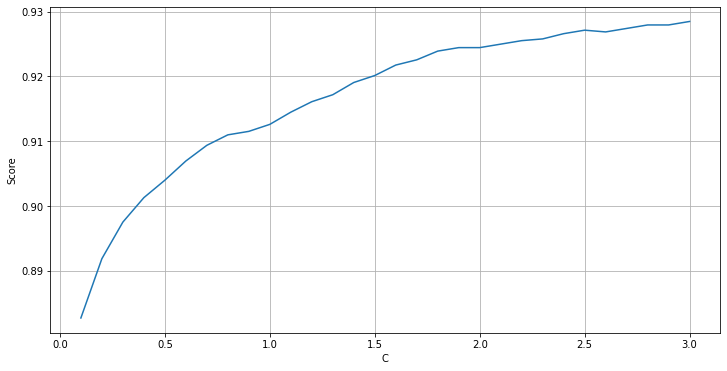

In [154]:
results = pd.DataFrame()
# collect alpha list
results['C'] = gs_clf.cv_results_['param_C'].data
# collect test scores
results['score'] = gs_clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results['C'], results['score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.grid()

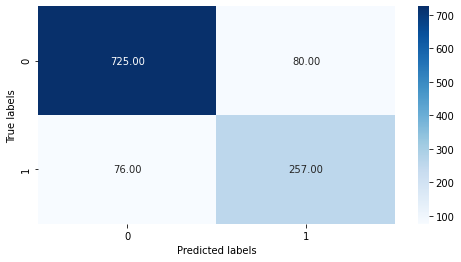

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       805
           1       0.76      0.77      0.77       333

    accuracy                           0.86      1138
   macro avg       0.83      0.84      0.84      1138
weighted avg       0.86      0.86      0.86      1138



In [155]:
preds = gs_clf.predict(segments_test)
#labels = segments['category_name'].unique()
cm = confusion_matrix(targets_test.astype(str), preds.astype(str))
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams['figure.figsize'] = (8, 4)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax = ax)
#ax.set_xticklabels([''] + labels, rotation=90)
#ax.set_yticklabels([''] + labels, rotation=0)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

#Quick diagnostics
print(classification_report(targets_test.astype(str),preds.astype(str)))

In [156]:
roc_auc_score(targets_test,preds)

0.8361964448920971